## Run the following setup code


In [1]:
# Parameters
dataset_patterns = "*"  # all of the datasets that are being run
method_patterns = "*"  # all of the methods to run
index = None
replace_runs = False  # whether to replace existing runs

In [2]:
index = int(index) if index is not None else None

In [3]:
%load_ext autoreload
%autoreload 2
import warnings
import numpy as np
import torch
import random
from dotenv import load_dotenv
import os
import sys
from utils import *

sys.path.append("..")
load_dotenv(override=True)

warnings.filterwarnings('ignore') # ignore warnings
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

dataset_patterns = dataset_patterns.split(",")
method_patterns = method_patterns.split(",")

# Set seeds for reproducibility
seed = 82718
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)


Load all the datasets


In [4]:
# Load datasets and required functions
%autoreload 2
from benchmarks import IHDPDataset, ACIC2016Dataset
from benchmarks import RealCauseLalondeCPSDataset, RealCauseLalondePSIDDataset

# Store all the results for all the datasets

IHDP = IHDPDataset()
ACIC2016 = ACIC2016Dataset()
RealCauseLalondeCPS = RealCauseLalondeCPSDataset()
RealCauseLalondePSID = RealCauseLalondePSIDDataset()

datasets = {
    "IHDP": IHDP if index is None else [IHDP[index%len(IHDP)]],
    "ACIC 2016": ACIC2016 if index is None else [ACIC2016[index%len(ACIC2016)]],
    "RealCause Lalonde CPS": RealCauseLalondeCPS if index is None else [RealCauseLalondeCPS[index%len(RealCauseLalondeCPS)]],
    "RealCause Lalonde PSID": RealCauseLalondePSID if index is None else [RealCauseLalondePSID[index%len(RealCauseLalondePSID)]],
}

causal_effect_path = os.path.join(os.environ["OUTPUT_DIR"], "causal_effect/")
os.makedirs(causal_effect_path, exist_ok=True)


## CausalPFN


In [5]:
from src.causalpfn import CATEEstimator, calculate_pehe, ATEEstimator
import time
from tqdm import tqdm

pbar = tqdm(
    total=sum([len(dataset) for dataset in datasets.values()]),
    desc="CausalPFN",
)
for dataset_name, dataset in datasets.items():
    pbar.set_postfix(dataset=dataset_name)
    for i in range(len(dataset)):
        # dataset_name: str, method_name: str, all_method_patterns: list, all_datasets_patterns: list, idx: int, artifact_dir: str, replace: bool = False
        with result_saver(
            dataset_name=dataset_name,
            method_name="CausalPFN",
            all_method_patterns=method_patterns,
            all_datasets_patterns=dataset_patterns,
            idx=i if index is None else index,
            artifact_dir=causal_effect_path,
            replace=replace_runs,
        ) as result:
            if result is not None:
                cate_dset, ate_dset = dataset[i]

                # CATE
                time_start = time.time()
                cate_estimator = CATEEstimator(
                    device=device,
                )
                cate_estimator.fit(cate_dset.X_train, cate_dset.t_train, cate_dset.y_train)
                estimated_cate = cate_estimator.estimate_cate(X=cate_dset.X_test)
                time_spent = time.time() - time_start
                pehe = calculate_pehe(cate_pred=estimated_cate, cate_true=cate_dset.true_cate)
                result["pehe"] = pehe
                result["time_cate"] = time_spent / (len(cate_dset.X_test) + len(cate_dset.X_train)) * 1000

                # ATE
                time_start = time.time()
                ate_estimator = ATEEstimator(
                    device=device,
                )
                ate_estimator.fit(ate_dset.X, ate_dset.t, ate_dset.y)
                estimated_ate = ate_estimator.estimate_ate()
                time_spent = time.time() - time_start
                result["ate_rel_err"] = abs(estimated_ate - ate_dset.true_ate) / abs(ate_dset.true_ate)
                result["time_ate"] = time_spent / len(ate_dset.X) * 1000

            pbar.update(1)
pbar.close()

CausalPFN: 100%|██████████| 310/310 [00:00<00:00, 5233.95it/s, dataset=RealCause Lalonde PSID]


## Baselines


In [6]:
# Baselines (Base)
from benchmarks.baselines import BaselineModel

# Baselines (EconML)
from benchmarks.baselines import (
    ForestDMLBaseline,
    TLearnerBaseline,
    SLearnerBaseline,
    XLearnerBaseline,
    DALearnerBaseline,
    XLearnerBaseline,
    ForestDRLearnerBaseline,
)

# Baselines (CATE Net)
from benchmarks.baselines import (
    TarNetBaseline,
    DragonNetBaseline,
    RANetBaseline,
    SNetBaseline,
    FlexTENetBaseline,
    XNetBaseline,
)

# GRF & BART & IPW
from benchmarks.baselines import GRFBaseline, BartBaseline, IPWBaseline


baselines = {
    "T Learner (no HPO)": TLearnerBaseline(hpo=False),
    "T Learner (HPO)": TLearnerBaseline(hpo=True),
    "S Learner (no HPO)": SLearnerBaseline(hpo=False),
    "S Learner (HPO)": SLearnerBaseline(hpo=True),
    "X Learner (no HPO)": XLearnerBaseline(hpo=False),
    "X Learner (HPO)": XLearnerBaseline(hpo=True),
    "DA Learner (no HPO)": DALearnerBaseline(hpo=False),
    "DA Learner (HPO)": DALearnerBaseline(hpo=True),
    "Forest DR Learner (no HPO)": ForestDRLearnerBaseline(hpo=False),
    "Forest DR Learner (HPO)": ForestDRLearnerBaseline(hpo=True),
    "Forest DML (no HPO)": ForestDMLBaseline(hpo=False),
    "Forest DML (HPO)": ForestDMLBaseline(hpo=True),
    "DragonNet (no HPO)": DragonNetBaseline(hpo=False),
    "DragonNet (HPO)": DragonNetBaseline(hpo=True),
    "TarNet (no HPO)": TarNetBaseline(hpo=False),
    "TarNet (HPO)": TarNetBaseline(hpo=True),
    "SNet (no HPO)": SNetBaseline(hpo=False),
    "SNet (HPO)": SNetBaseline(hpo=True),
    "FlexTENet (no HPO)": FlexTENetBaseline(hpo=False, batch_size=256),
    "FlexTENet (HPO)": FlexTENetBaseline(hpo=True, batch_size=256),
    "XNET (no HPO)": XNetBaseline(hpo=False, batch_size=256),
    "XNET (HPO)": XNetBaseline(hpo=True, batch_size=256),
    "RA Net (no HPO)": RANetBaseline(hpo=False),
    "RA Net (HPO)": RANetBaseline(hpo=True),
    "GRF (no HPO)": GRFBaseline(hpo=False),
    "GRF (HPO)": GRFBaseline(hpo=True),
    "BART": BartBaseline(hpo=False),
    "IPW (no HPO)": IPWBaseline(hpo=False),
    "IPW (HPO)": IPWBaseline(hpo=True),
}


pbar = tqdm(
    total=sum([len(dataset) * len(baselines) for dataset in datasets.values()]),
    desc="Baselines",
)

for dataset_name, dataset in datasets.items():
    for baseline_name, baseline in baselines.items():
        pbar.set_postfix(dataset=dataset_name, baseline=baseline_name)
        for i in range(len(dataset)):
            with result_saver(
                dataset_name=dataset_name,
                method_name=baseline_name,
                all_method_patterns=method_patterns,
                all_datasets_patterns=dataset_patterns,
                idx=i if index is None else index,
                artifact_dir=causal_effect_path,
                replace=replace_runs,
            ) as result:
                if result is not None:
                    baseline: BaselineModel
                    cate_dset, ate_dset = dataset[i]

                    # CATE
                    start_time = time.time()
                    cate_pred = baseline.estimate_cate(
                        X_train=cate_dset.X_train,
                        t_train=cate_dset.t_train,
                        y_train=cate_dset.y_train,
                        X_test=cate_dset.X_test,
                    )
                    time_spent = time.time() - start_time
                    pehe = calculate_pehe(cate_true=cate_dset.true_cate, cate_pred=cate_pred)
                    result["pehe"] = pehe
                    result["time_cate"] = time_spent / (len(cate_dset.X_test) + len(cate_dset.X_train)) * 1000

                    # ATE
                    start_time = time.time()
                    ate_pred = baseline.estimate_ate(
                        X=ate_dset.X,
                        t=ate_dset.t,
                        y=ate_dset.y,
                    )
                    time_spent = time.time() - start_time
                    result["ate_rel_err"] = abs(ate_pred - ate_dset.true_ate) / abs(ate_dset.true_ate)
                    result["time_ate"] = time_spent / len(ate_dset.X) * 1000
                pbar.update(1)
pbar.close()

Baselines: 100%|██████████| 8990/8990 [00:02<00:00, 4393.65it/s, baseline=IPW (HPO), dataset=RealCause Lalonde PSID]                 


## Parse and visualize all of the results

Once done, parse all of the results that were stored with the following code into a dataframe. This dataframe will contain different rows for each causal task and columns for the dataset, fold, method, and metric.


In [10]:
import pandas as pd

methods_to_show = ["CausalPFN"] + list(baselines.keys())
methods_to_show = [method for method in methods_to_show if any([check_match(method, m) for m in method_patterns])]
results_df = pd.DataFrame(
    columns=["dataset", "method", "cate_pehe", "ate_rel_err", "cate_time", "ate_time", "realization"]
)
for dataset_name, dataset in datasets.items():
    dset_result = load_all_results(dataset_name, causal_effect_path)
    for method in methods_to_show:
        all_rows = dset_result[method]
        num_realizations = len(all_rows["pehe"])
        for fold_idx in range(num_realizations):
            pehe = float(all_rows["pehe"][fold_idx])
            ate_rel_err = float(all_rows["ate_rel_err"][fold_idx])
            time_cate = float(all_rows["time_cate"][fold_idx])
            time_ate = float(all_rows["time_ate"][fold_idx])
            new_row = dict(
                dataset=dataset_name,
                method=method,
                cate_pehe=pehe,
                ate_rel_err=ate_rel_err,
                cate_time=time_cate,
                ate_time=time_ate,
                realization=fold_idx,
            )
            results_df = pd.concat([results_df, pd.DataFrame(new_row, index=[0])], ignore_index=True)

Once done, you can load the results below:


In [12]:
# summarize all of the ATE and CATE estimation times by averaging over realizations
time_spent_df = (
    results_df.pivot_table(
        index="method",  # rows: one per method
        columns="dataset",  # multi‐columns: first level will be dataset
        values=["ate_time", "cate_time"],  # the values to aggregate
        aggfunc="mean",  # take the mean over realizations
    )
    .swaplevel(0, 1, axis=1)
    .sort_index(axis=1, level=0)
)

# Compute mean and standard error for ATE and CATE metrics
metrics = ["cate_pehe", "ate_rel_err"]
grp = results_df.groupby(["method", "dataset"])[metrics].agg(["mean", "sem"])  # MultiIndex cols: (metric, agg)
methods = grp.index.levels[0]
datasets_index = grp.index.levels[1]
data = {}
for ds in datasets_index:
    for m in metrics:
        means = grp[(m, "mean")].xs(ds, level="dataset")
        sems = grp[(m, "sem")].xs(ds, level="dataset")
        # combine into "xx.xx ± yy.yy" strings
        data[(ds, m)] = means.combine(sems, lambda mu, se: f"{mu:.2f} ± {se:.2f}")
causal_effect_errors = pd.DataFrame(data, index=methods)
causal_effect_errors.columns = pd.MultiIndex.from_tuples(causal_effect_errors.columns, names=["dataset", "metric"])
causal_effect_errors = causal_effect_errors.sort_index(axis=1, level=0)

Compute total performance for CATE (rank of PEHE), and ATE (average relative error) for each method and all causal tasks (across different realizations of each method). Then visualize all of the error rates.


In [13]:
from collections import defaultdict

ate_errors = defaultdict(list)
cate_pehes = defaultdict(list)
for dataset_name, dataset in datasets.items():
    dset_result = load_all_results(dataset_name, causal_effect_path)
    for method in methods_to_show:
        all_rows = dset_result[method]
        num_realizations = len(all_rows["pehe"])
        for fold_idx in range(num_realizations):
            pehe = float(all_rows["pehe"][fold_idx])
            ate_rel_err = float(all_rows["ate_rel_err"][fold_idx])
            ate_errors[method].append(ate_rel_err)
            cate_pehes[method].append(pehe)


def get_ranks(res: dict):
    ranks = {}
    ranks_ste = {}
    for method in methods_to_show:
        all_len = len(res[method])
        all_ranks = []
        for idx in range(all_len):
            rank = 0
            for other_methods in methods_to_show:
                our_res = res[method][idx]
                other_res = res[other_methods][idx]
                rank += our_res >= other_res
            all_ranks.append(rank)
        ranks[method] = sum(all_ranks) / all_len
        ranks_ste[method] = np.std(all_ranks) / np.sqrt(all_len)
    return ranks, ranks_ste


cate_ranks, cate_ranks_ste = get_ranks(cate_pehes)
ate_ranks, ate_ranks_ste = get_ranks(ate_errors)

# add a multicolumn to causal_effect_errors called "overall"
causal_effect_errors[("overall", "cate_rank ± ste")] = pd.Series(
    {method: f"{cate_ranks[method]:.2f} ± {cate_ranks_ste[method]:.2f}" for method in methods_to_show}
)
causal_effect_errors[("overall", "ate_rank ± ste")] = pd.Series(
    {method: f"{ate_ranks[method]:.2f} ± {ate_ranks_ste[method]:.2f}" for method in methods_to_show}
)

causal_effect_errors[("overall", "rank")] = (pd.Series(cate_ranks) + pd.Series(ate_ranks)) / 2
# sort rows by rank
causal_effect_errors = causal_effect_errors.sort_values(by=("overall", "rank"))
causal_effect_errors

dataset                       ACIC 2016                      IHDP  \
metric                      ate_rel_err    cate_pehe  ate_rel_err   
method                                                              
CausalPFN                   0.05 ± 0.01  0.92 ± 0.11  0.20 ± 0.04   
T Learner (HPO)             0.03 ± 0.01  0.76 ± 0.07  0.21 ± 0.04   
DA Learner (no HPO)         0.09 ± 0.03  1.88 ± 0.24  0.22 ± 0.04   
DA Learner (HPO)            0.03 ± 0.01  0.72 ± 0.08  0.23 ± 0.04   
T Learner (no HPO)          0.11 ± 0.03  2.06 ± 0.20  0.22 ± 0.04   
IPW (HPO)                   0.21 ± 0.05  3.20 ± 0.61  0.24 ± 0.04   
IPW (no HPO)                0.24 ± 0.05  3.22 ± 0.62  0.23 ± 0.04   
FlexTENet (HPO)             0.04 ± 0.01  2.30 ± 0.26  0.21 ± 0.04   
DragonNet (no HPO)          0.09 ± 0.02  2.23 ± 0.20  0.21 ± 0.04   
DragonNet (HPO)             0.06 ± 0.02  2.11 ± 0.19  0.20 ± 0.04   
RA Net (HPO)                0.07 ± 0.03  2.35 ± 0.25  0.20 ± 0.04   
XNET (HPO)                  0.06 ± 0.02  2.34 ± 0.26  0.20 ± 0.03   
SNet (no HPO)               0.04 ± 0.01  1.46 ± 0.17  0.21 ± 0.04   
X Learner (HPO)             0.03 ± 0.01  0.60 ± 0.08  0.16 ± 0.04   
TarNet (no HPO)             0.06 ± 0.02  2.26 ± 0.20  0.21 ± 0.04   
X Learner (no HPO)          0.07 ± 0.02  1.71 ± 0.31  0.19 ± 0.03   
GRF (no HPO)                0.07 ± 0.02  1.36 ± 0.30  0.18 ± 0.03   
RA Net (no HPO)             0.07 ± 0.03  2.42 ± 0.22  0.20 ± 0.04   
GRF (HPO)                   0.07 ± 0.02  1.32 ± 0.30  0.18 ± 0.03   
S Learner (HPO)             0.03 ± 0.01  0.85 ± 0.13  0.20 ± 0.04   
BART                        0.04 ± 0.01  0.68 ± 0.11  0.44 ± 0.09   
TarNet (HPO)                0.05 ± 0.02  2.20 ± 0.21  0.20 ± 0.04   
SNet (HPO)                  0.06 ± 0.01  1.22 ± 0.15  0.93 ± 0.02   
Forest DR Learner (no HPO)  0.08 ± 0.04  1.68 ± 0.35  0.19 ± 0.04   
Forest DR Learner (HPO)     0.04 ± 0.02  1.34 ± 0.29  0.17 ± 0.03   
Forest DML (HPO)            0.05 ± 0.01  1.48 ± 0.31  0.08 ± 0.01   
S Learner (no HPO)          0.12 ± 0.05  2.23 ± 0.28  0.28 ± 0.05   
Forest DML (no HPO)         0.05 ± 0.02  1.47 ± 0.32  0.09 ± 0.02   
XNET (no HPO)               1.00 ± 0.00  4.95 ± 0.51  1.00 ± 0.00   
FlexTENet (no HPO)          1.00 ± 0.00  4.95 ± 0.51  1.00 ± 0.00   

dataset                                 RealCause Lalonde CPS  \
metric                        cate_pehe           ate_rel_err   
method                                                          
CausalPFN                   0.58 ± 0.07           0.13 ± 0.01   
T Learner (HPO)             1.73 ± 0.30           0.24 ± 0.02   
DA Learner (no HPO)         2.98 ± 0.51           0.22 ± 0.01   
DA Learner (HPO)            2.07 ± 0.36           0.27 ± 0.02   
T Learner (no HPO)          2.94 ± 0.49           0.40 ± 0.01   
IPW (HPO)                   5.70 ± 0.89           0.17 ± 0.01   
IPW (no HPO)                5.70 ± 0.89           0.22 ± 0.01   
FlexTENet (HPO)             2.08 ± 0.11           0.53 ± 0.02   
DragonNet (no HPO)          2.13 ± 0.24           0.56 ± 0.03   
DragonNet (HPO)             2.16 ± 0.25           0.55 ± 0.03   
RA Net (HPO)                2.35 ± 0.19           0.74 ± 0.02   
XNET (HPO)                  3.02 ± 0.34           0.63 ± 0.03   
SNet (no HPO)               2.12 ± 0.13           0.79 ± 0.02   
X Learner (HPO)             3.31 ± 0.51           0.84 ± 0.03   
TarNet (no HPO)             1.89 ± 0.15           0.90 ± 0.01   
X Learner (no HPO)          3.70 ± 0.62           0.83 ± 0.01   
GRF (no HPO)                4.26 ± 0.69           0.81 ± 0.02   
RA Net (no HPO)             2.08 ± 0.19           0.96 ± 0.02   
GRF (HPO)                   3.67 ± 0.61           0.82 ± 0.02   
S Learner (HPO)             2.57 ± 0.41           0.97 ± 0.01   
BART                        2.50 ± 0.39           0.99 ± 0.01   
TarNet (HPO)                1.82 ± 0.14           1.00 ± 0.00   
SNet (HPO)                  7.50 ± 0.81           1.00 ± 0.00   
Forest DR Learner (no HPO)  3.90

Compute average time for each method and add that to the dataframe of times and sort according to that average.


In [14]:
from collections import defaultdict
import numpy as np

ate_times = defaultdict(list)
cate_times = defaultdict(list)
for dataset_name, dataset in datasets.items():
    dset_result = load_all_results(dataset_name, causal_effect_path)
    for method in methods_to_show:
        all_rows = dset_result[method]
        num_realizations = len(all_rows["pehe"])
        for fold_idx in range(num_realizations):
            cate_time = float(all_rows["time_cate"][fold_idx])
            ate_time = float(all_rows["time_ate"][fold_idx])
            ate_times[method].append(ate_time)
            cate_times[method].append(cate_time)
med_ate_times = {}
med_cate_times = {}
for method in methods_to_show:
    med_ate_times[method] = np.median([ate_times[method][i] for i in range(len(ate_times[method]))])
    med_cate_times[method] = np.median([cate_times[method][i] for i in range(len(cate_times[method]))])

# add a multicolumn to causal_effect_errors called "overall"
time_spent_df[("overall", "ate_time")] = pd.Series(med_ate_times)
time_spent_df[("overall", "cate_time")] = pd.Series(med_cate_times)
# sort rows by rank
time_spent_df = time_spent_df.sort_values(by=("overall", "cate_time"))
time_spent_df

dataset                       ACIC 2016                      IHDP  \
                               ate_time    cate_time     ate_time   
method                                                              
FlexTENet (no HPO)             0.000857     0.000758     0.001603   
IPW (no HPO)                   0.064492     0.059753     0.127351   
S Learner (no HPO)             0.075717     0.075550     0.466148   
T Learner (no HPO)             0.120445     0.116674     0.916476   
DA Learner (no HPO)            0.279503     0.283248     2.078678   
CausalPFN                      1.778429     0.630637     1.876200   
GRF (no HPO)                   3.273261     1.051030     4.624504   
X Learner (no HPO)             0.325441     0.328857     2.628365   
TarNet (no HPO)                1.276442     1.293894     5.316109   
DragonNet (no HPO)             1.487617     1.506751     4.642988   
GRF (HPO)                      3.351523     3.142087     4.533691   
XNET (no HPO)                  4.372944     3.655362    12.249859   
RA Net (no HPO)                5.002618     4.501656    13.268286   
Forest DR Learner (no HPO)   483.112359   424.962053    28.169275   
Forest DML (no HPO)          630.151684   554.478033    36.546051   
SNet (no HPO)                  4.015937     3.883040    10.951375   
XNET (HPO)                     6.903680     6.246199    19.711522   
FlexTENet (HPO)                5.264130     5.236548    15.552939   
BART                           5.016562     4.509301     6.438867   
TarNet (HPO)                  23.137612    23.758678    92.663927   
DragonNet (HPO)               25.612350    26.379348   101.961289   
RA Net (HPO)                  57.229469    55.611749   241.409582   
SNet (HPO)                    79.072716    79.283878   103.045946   
IPW (HPO)                    187.445818   187.450784  1205.191209   
S Learner (HPO)              187.785203   188.501705  1205.187853   
T Learner (HPO)              375.362602   375.225016  1805.152096   
X Learner (HPO)              562.901286   562.840737  3431.698731   
Forest DR Learner (HPO)      826.427797   774.391367  1711.189979   
Forest DML (HPO)            1230.262155  1117.191892  2463.427748   
DA Learner (HPO)             750.537069   750.231691  4819.948724   

dataset                                 RealCause Lalonde CPS              \
                              cate_time              ate_time   cate_time   
method                                                                      
FlexTENet (no HPO)             0.001670              0.000160    0.000218   
IPW (no HPO)                   0.125096              0.042458    0.040139   
S Learner (no HPO)             0.454180              0.021364    0.021157   
T Learner (no HPO)             0.883767              0.044261    0.043567   
DA Learner (no HPO)            2.076818              0.088429    0.089609   
CausalPFN                      0.673687              3.061373    0.818941   
GRF (no HPO)                   0.596345              2.189785    0.708011   
X Learner (no HPO)             2.585276              0.105608    0.105298   
TarNet (no HPO)                5.866852              0.231617    0.314323   
DragonNet (no HPO)             4.659946              0.599383    1.168565   
GRF (HPO)                      4.573715              2.226246    2.130062   
XNET (no HPO)                 12.194790              1.573581    1.346342   
RA Net (no HPO)               14.892828              1.051872    1.129872   
Forest DR Learner (no HPO)    25.474570              3.271908    2.920928   
Forest DML (no HPO)           32.682874              4.319115    3.836490   
SNet (no HPO)                 11.515392              0.354591    0.578330   
XNET (HPO)                    21.350684              2.749048    2.440719   
FlexTENet (HPO)               16.792147              1.357712    1.657927   
BART                           5.668311             11.458935    9.506232   
TarNet (HPO)                

## Generate Figure 1 (Teaser)

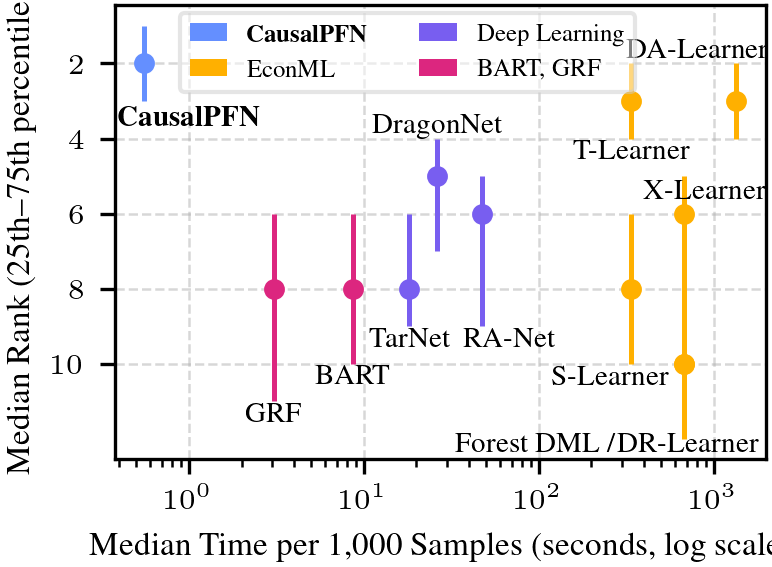

In [21]:
import matplotlib.patches as mpatches

df = results_df.copy()

# replace method names for better visualization
method_name_map = {
    "CausalPFN": "CausalPFN",
    "T Learner (HPO)": "T-Learner",
    "S Learner (HPO)": "S-Learner",
    "X Learner (HPO)": "X-Learner",
    "DA Learner (HPO)": "DA-Learner",
    "Forest DR Learner (HPO)": "DR-Learner",
    "Forest DML (HPO)": "Forest DML",
    "DragonNet (HPO)": "DragonNet",
    "TarNet (HPO)": "TarNet",
    "RA Net (HPO)": "RA-Net",
    "GRF (HPO)": "GRF",
    "BART": "BART",
}
df["method"] = df["method"].map(method_name_map)

# drop nan rows
df = df.dropna()

with graph_theme():
    methods = method_name_map.values()

    # Group mapping
    group_map = {
        "CausalPFN": r"CausalPFN",
        "T-Learner": r"EconML",
        "S-Learner": r"EconML",
        "X-Learner": r"EconML",
        "DA-Learner": r"EconML",
        "DR-Learner": r"EconML",
        "Forest DML": r"EconML",
        "GRF": r"BART, GRF",
        "BART": r"BART, GRF",
        "RA-Net": r"Deep Learning",
        "DragonNet": r"Deep Learning",
        "TarNet": r"Deep Learning",
    }
    df_filtered = df[df["method"].isin(methods)]

    df_ranked = (
        df_filtered.groupby(["dataset", "realization"])
        .apply(lambda x: x.assign(rank=x["cate_pehe"].rank()))
        .reset_index(drop=True)
    )

    df_ranked["group"] = df_ranked["method"].map(group_map)

    method_stats = df_ranked.groupby("method").agg(
        {
            "rank": ["median", lambda x: x.quantile(0.25), lambda x: x.quantile(0.75)],
            "cate_time": ["median", lambda x: x.quantile(0.25), lambda x: x.quantile(0.75)],
            "group": "first",
        }
    )
    method_stats.columns = [
        "median_rank",
        "q1_rank",
        "q3_rank",
        "median_cate_time",
        "q1_cate_time",
        "q3_cate_time",
        "group",
    ]
    method_stats = method_stats.reset_index().sort_values("median_cate_time")

    color_map = {"CausalPFN": "#648fff", "EconML": "#FFB000", "Deep Learning": "#785ef0", "BART, GRF": "#dc267f"}
    legend_order = ["CausalPFN", "EconML", "Deep Learning", "BART, GRF"]

    fig, ax = plt.subplots(figsize=(NEURIPS_COL_SIZE / 2, NEURIPS_COL_SIZE / 2 * 0.75))

    for i, row in method_stats.iterrows():
        color = color_map[row["group"]]

        ax.vlines(x=row["median_cate_time"], ymin=row["q1_rank"], ymax=row["q3_rank"], color=color)

        ax.plot(row["median_cate_time"], row["median_rank"], color=color, marker="o", linestyle="None")

        # Adjust the label positions based on method
        label_y = row["q3_rank"] + 0.7
        name = row["method"] if row["method"] != "CausalPFN" else r"\textbf{CausalPFN}"
        label_x = row["median_cate_time"]
        if row["method"] == "RA-Net":
            label_x = row["median_cate_time"] + 20
        if row["method"] == "DragonNet":
            label_y = row["q3_rank"] - 3
        if row["method"] == "DA-Learner":
            label_y = row["q3_rank"] - 2
            label_x = row["median_cate_time"] - 550
        if row["method"] == "CausalPFN":
            label_y = row["q3_rank"] + 0.8
            label_x = row["median_cate_time"] + 0.45
        if row["method"] == "Forest DML":
            label_y = row["q3_rank"] + 1.5
            label_x = row["median_cate_time"] - 585
            name = "Forest DML / "
        if row["method"] == "DR-Learner":
            label_y = row["q3_rank"] + 0.5
            label_x = row["median_cate_time"] + 30
        if row["method"] == "X-Learner":
            label_y = row["median_rank"] - 0.25
            label_x = row["median_cate_time"] + 200
        if row["method"] == "S-Learner":
            label_x = row["median_cate_time"] - 80
        ax.text(label_x, label_y, name, ha="center", va="bottom")

    legend_elements = [mpatches.Patch(facecolor=color_map[group], label=group) for group in legend_order]
    legend_elements[0].set_label(r"\textbf{CausalPFN}")
    ax.legend(handles=legend_elements, loc=(0.1, 0.81), frameon=True, ncol=2, framealpha=0.5)

    ax.set_xscale("log")
    ax.set_xlabel(r"Median Time per 1,000 Samples (seconds, log scale)", fontsize=8)

    ax.set_ylabel(r"Median Rank (25th–75th percentile)", fontsize=8)
    ax.invert_yaxis()
    ax.set_yticks([2, 4, 6, 8, 10])

    plt.tight_layout()
    plt.show()